C:\Users\delar\anaconda3\envs\my-rdkit-env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: California_Fire_Perimeters_(all).shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


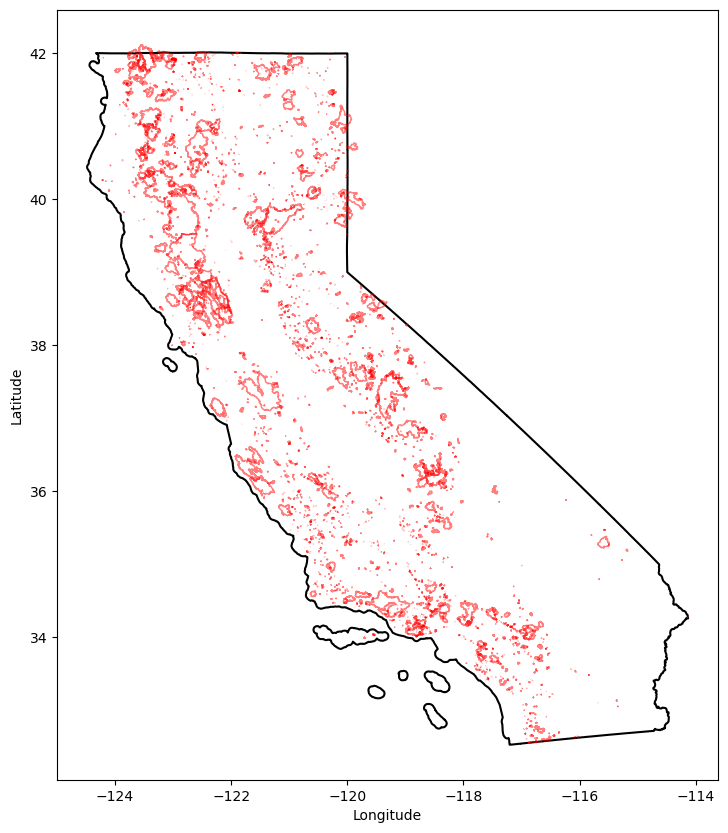

In [ ]:
#Load in necessary imports to read and plot shapely files
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon as ShapelyPolygon, MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

# Load shapefile and unify the boundary
gdf = gpd.read_file('California_Fire_Perimeters_(all).shp')
gdf = gdf.to_crs("EPSG:4326")

# Load shapefile and unify the boundary
gd = gpd.read_file('CA_State.shp')
gd = gd.to_crs("EPSG:4326")
state_shape = gd.union_all()

fig, ax = plt.subplots(figsize=(10, 10))
gd.boundary.plot(ax=ax, color='black', linewidth=1.5)
gdf.boundary.plot(ax=ax, color='red', linewidth=1, alpha=0.5)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

C:\Users\delar\anaconda3\envs\my-rdkit-env\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: California_Fire_Perimeters_(all).shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


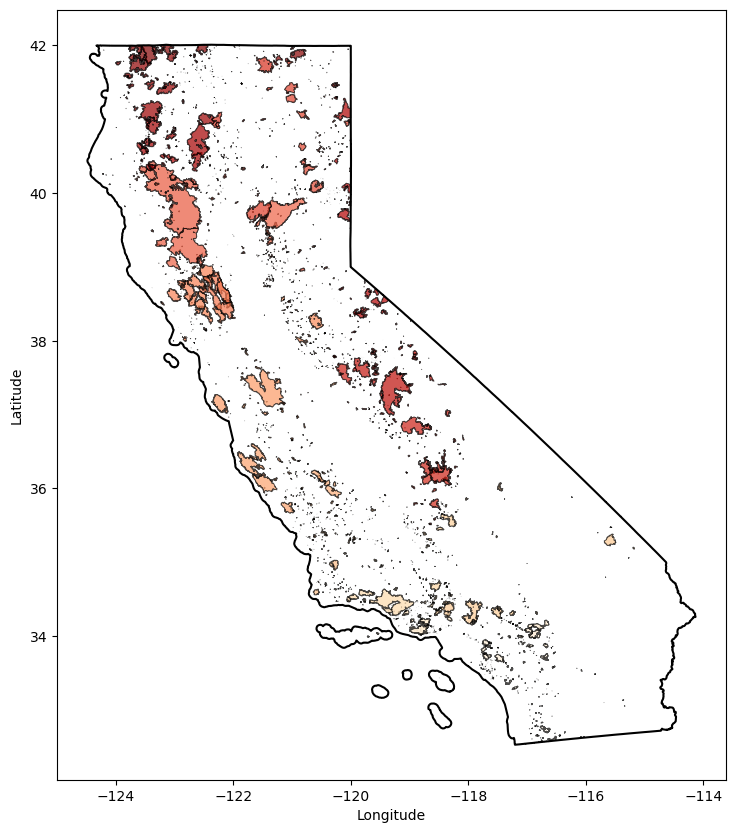

In [ ]:
# Script For Organizing Data
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon as ShapelyPolygon, MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

# Load state boundary
gd = gpd.read_file('CA_State.shp').to_crs("EPSG:4326")
state_shape = gd.union_all()

# Load fire perimeters
fires = gpd.read_file('California_Fire_Perimeters_(all).shp').to_crs("EPSG:4326")

# Load coordinates from Excel
coord = pd.read_excel('2015_to_2020.xlsx')
coord_unique = coord.drop_duplicates(subset=['LATITUDE', 'LONGITUDE'])
points = coord_unique[['LONGITUDE','LATITUDE']].to_numpy()

# Add bounding points to avoid infinite Voronoi regions
points = np.append(points, [[-140,45], [-140,25], [-100,45], [-100,25]], axis=0)

# Create Voronoi diagram
vor = Voronoi(points)

# Clip Voronoi regions to the state shape
regions = []
centroids = []
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if not region or -1 in region:
        continue
    polygon = ShapelyPolygon([vor.vertices[i] for i in region])
    if polygon.is_valid:
        clipped = polygon.intersection(state_shape)
        if not clipped.is_empty:
            regions.append(clipped)
            centroids.append(clipped.centroid)

# Create GeoDataFrame for Voronoi regions
voronoi_gdf = gpd.GeoDataFrame({'geometry': regions, 'centroid': centroids}, crs="EPSG:4326")

# Spatial join: intersect Voronoi regions with fire perimeters
# Make sure both are in the same CRS and simplify fire shapes if needed
intersections = gpd.sjoin(
    voronoi_gdf.set_geometry('geometry'),
    fires,
    how='inner',
    predicate='intersects'
)

# Extract fire info and centroid coordinates
results = pd.DataFrame({
    'OBJECTID': intersections['OBJECTID'],  # Replace with actual fire column if different
    'CENTROID_LAT': intersections['centroid'].y,
    'CENTROID_LON': intersections['centroid'].x
})

# Save to Excel
results.to_excel('fire_voronoi_mapping.xlsx', index=False)